Preamble: import these plotting utilities

In [2]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Revisiting the coauthorship graph

+ Coauthorship among physicists based arXiv postings in `astro-ph`
+ The graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003
+ If Author i and Author j coauthored a paper during that period, the nodes are connected
+ In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors
+ This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)



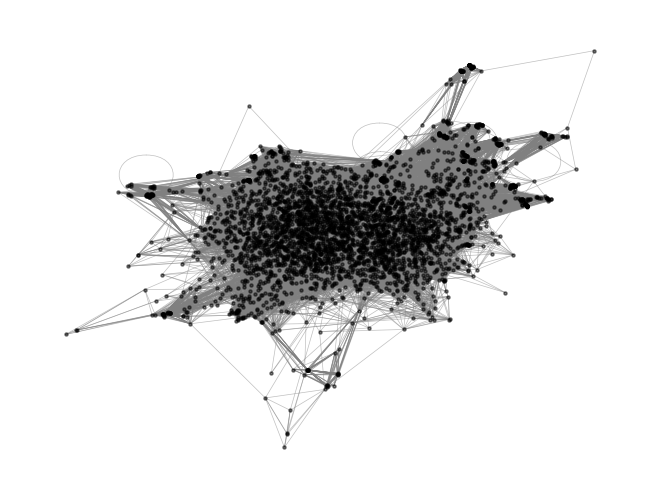

In [3]:
import networkx as nx

## Load the full coauthorship network
fpath = "../resources/ca-AstroPh.txt.gz"
# fpath = "../resources/ca-CondMat.txt.gz"
g = nx.read_edgelist(fpath)

## Create a subgraph of the 1000 most connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

## Implementing the PageRank algorithm

We are now going to implement the PageRank algorithm, which ranks the nodes in the coauthorship graph according to their importance. Here, importance is defined in terms of how frequently a random web surfer will visit a node in the long run.

The PageRank algorithm finds a vector $R \in \mathbb{R}^N$ such that
$$
\mathbf{R} = \alpha A \mathbf{R} + (1 - \alpha) \mathbb{1}
$$

where $\mathbb{1}$ is a vector of ones, $A$ is the adjacency matrix of the graph, and $\alpha$ is a parameter that controls the probability of the random surfer jumping to a random node. This equation can be rewritten as an equation for $\mathbf{R}$,

$$
\mathbf{R} = (1 - \alpha) (I - \alpha A D^{-1})^{-1}  \mathbb{1}
$$

where $I$ is the identity matrix and $D$ is the degree matrix. We write these equations as a single matrix equation

$$
\mathbf{R} = \mathbf{M}^{-1} \mathbb{1}
$$

where $\mathbf{M} \equiv (1 - \alpha) (I - \alpha A D^{-1})$.


In [4]:
A = nx.adjacency_matrix(g2).todense() # get the binary adjacency matrix of the graph
D = np.diag(np.sum(A, axis=1)) # get the degree matrix

alpha = 0.85 # a typical damping factor used in PageRank
M = (1 - alpha) * (np.eye(A.shape[0]) - alpha * np.matmul(A, np.linalg.inv(D)))


# Inverting a matrix

We have taken for granted, so far, that we can invert a large matrix $\mathbf{A}$. Given a linear problem
$$
A \mathbf{x} = \mathbf{b}
$$
with $A \in \mathbb{R}^{N \times N}$, $\mathbf{x} \in \mathbb{R}^N$, and $\mathbf{b} \in \mathbb{R}^N$, we can solve for $\mathbf{x}$ by inverting $A$:
$$
\mathbf{x} = A^{-1} \mathbf{b}
$$

#### How would we do this by hand?

Gauss-Jordan elimination: perform a series of operations on both the left and the right hand sides of our equation (changing both $A$ and $\mathbf{b}$), until the left side of the equation is triangular in form. Because Gauss-Jordan elimination consists of a series of row-wise addition and subtraction operations, we can think of the process as writing each row vector in terms of some linear combination of row vectors, making the whole process expressible as a matrix $M$

$$
(M A) \mathbf{x} = M \mathbf{b} \\
$$
$$
U \mathbf{x} = M \mathbf{b} \\
$$
where we have defined the upper-triangular matrix $U \equiv MA$. This confirms our intuition that the time complexity of Gauss-Jordan elimination is $\sim\mathcal{O}(N^3)$, since that's the time complexity of multiplying two $N \times N$ matrices.

#### Why do we want triangular matrices?

If we can reduce our matrix $A$ to upper-triangular form, then we can quickly solve for $\mathbf{x}$ using forward substitution. This should take $\sim\mathcal{O(N^2)}$ operations if $A \in \mathbb{R}^{N \times N}$

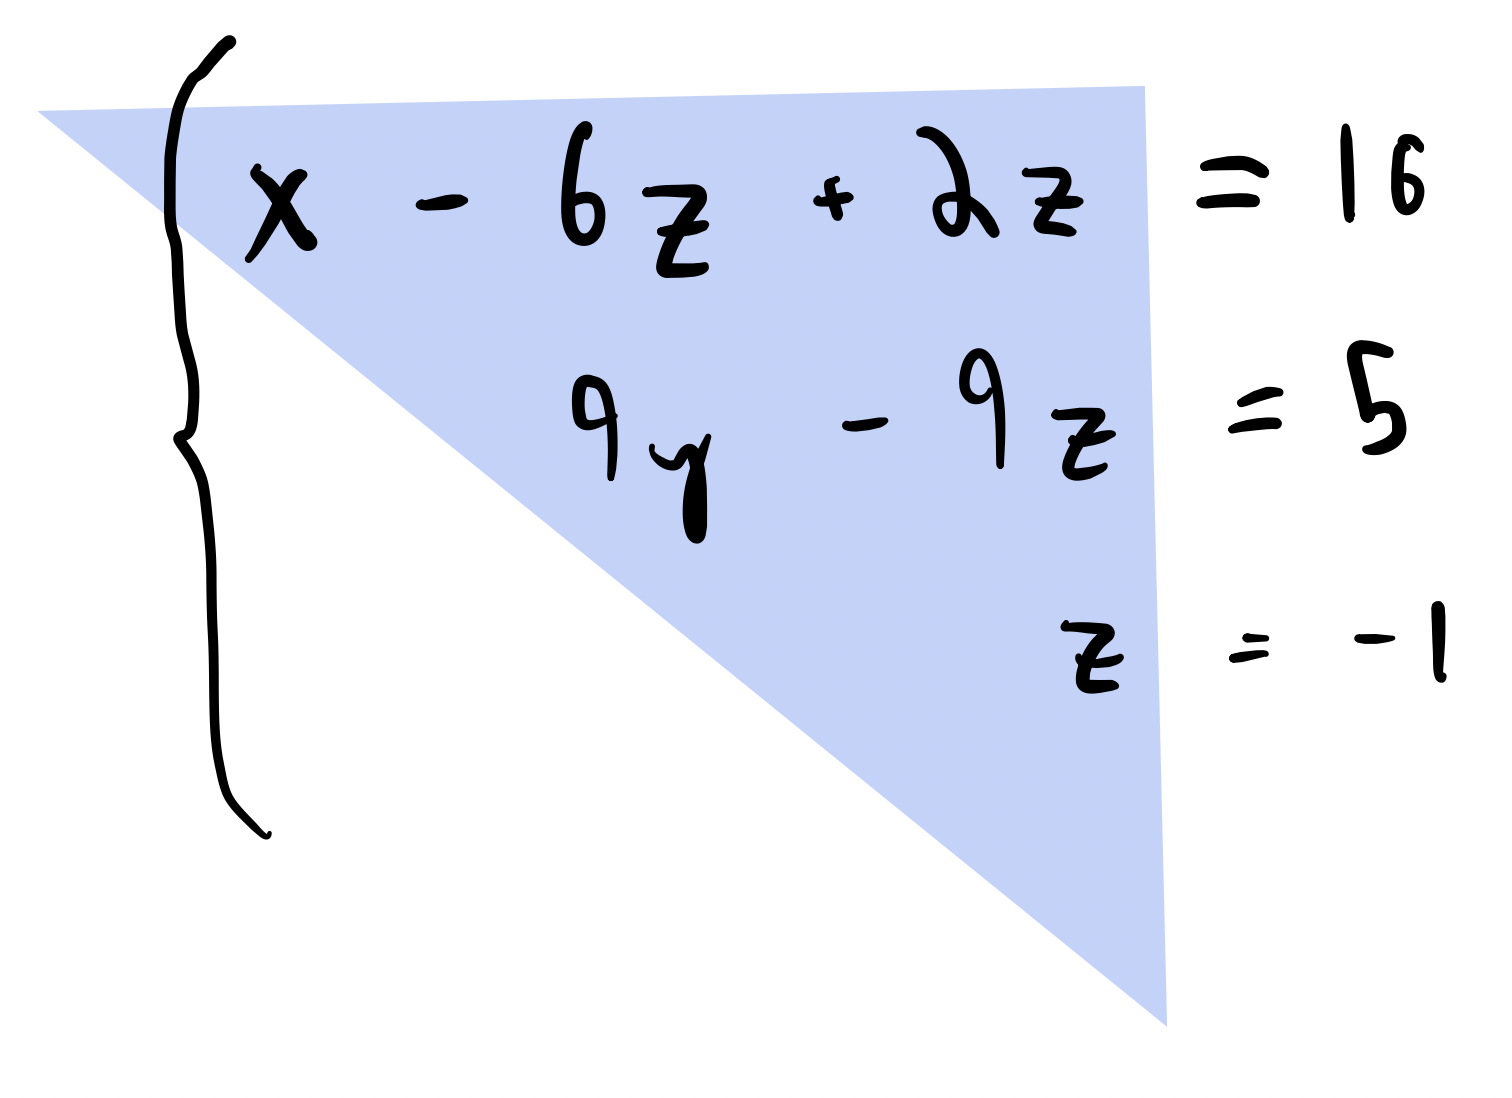

In [3]:
Image("../resources/triangular.png", width=600)

In [117]:

def solve_tril(a, b):
    """
    Given a triangular matrix, solve using forward subtitution

    Args:
        a (np.ndarray): A lower triangular matrix
        b (np.ndarray): A vector

    Returns:
        x (np.ndarray): The solution to the system
    """
    #a = a.T # make it lower triangular for cleaner notation
    n = a.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(a[i, :i], x[:i])) / a[i, i]
    return x
    
# A random lower triangular matrix
a = np.tril(np.random.random((10, 10)))
b = np.random.random(10)

print(np.linalg.solve(a, b))
print(solve_tril(a, b))

# Check that the numpy and our implementation give the same result
print(np.allclose(np.linalg.solve(a, b), solve_tril(a, b)))



[  0.65992466   0.32830238  -0.25257279   3.48492801  -5.93032238
  -2.57856074  19.46271838 -14.46514234  73.19753098 -84.13021322]
[  0.65992466   0.32830238  -0.25257279   3.48492801  -5.93032238
  -2.57856074  19.46271838 -14.46514234  73.19753098 -84.13021322]
True


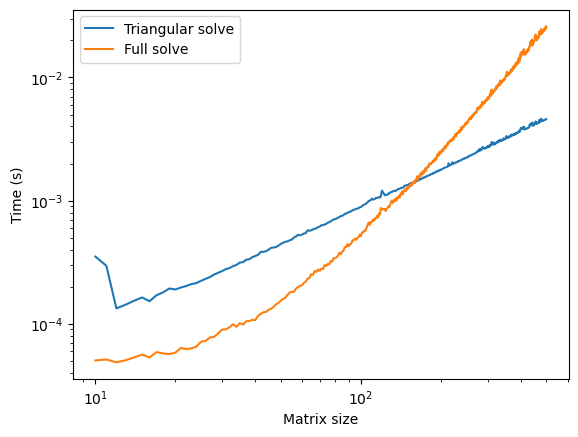

In [121]:
import timeit

all_times1, all_times2 = list(), list()
nvals = np.arange(10, 500)
for n in nvals:
    ## Upper triangular solve
    a = np.tril(np.random.random((n, n)))
    b = np.random.random(n)
    all_reps = [timeit.timeit("solve_tril(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times1.append(np.mean(all_reps))

    ## Full solve
    a = np.random.random((n, n))
    b = np.random.random(n)
    all_reps = [timeit.timeit("np.linalg.solve(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times2.append(np.mean(all_reps))

plt.loglog(nvals, all_times1, label="Triangular solve")
plt.loglog(nvals, all_times2, label="Full solve")
plt.xlabel("Matrix size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

## So to invert a matrix, we just need to reach triangular form

We know that we want to modify our full matrix equation 
$$
A \mathbf{x} = \mathbf{b}
$$ 
using a Gauss-Jordan elimination procedure, which we know has the form of a matrix multiplication
$$
M A \mathbf{x} = M \mathbf{b}
$$ 
We define $U \equiv M A$, and we know that we want to reduce $U$ to upper-triangular form.
$$
U \mathbf{x} = M \mathbf{b}
$$
But what is the form of $M$? 

**Our key insight is that the matrix $M$ turns out to be a triangular matrix as well.**

Moreover, because the inverse of a triangular matrix is also a triangular matrix (this can be proven by writing out the matrix multiplication algebra for $U^{-1} U = I$), we therefore write a transformed version of our problem

$$
U \mathbf{x} = M \mathbf{b}
$$
defining $M \equiv L^{-1}$, we arrive at the celebrated LU matrix factorization 
$$
L U \mathbf{x} = \mathbf{b}
$$
where $L$ is a lower triangular matrix, and $U$ is an upper triangular matrix.

We can therefore solve for $\mathbf{x}$ by introducing an intermediate variable $\mathbf{h}$, and then $\mathbf{x}$
$$
LU \mathbf{x} = \mathbf{b} \\
L \mathbf{h} = \mathbf{b} \\
$$
where $\mathbf{h} \equiv U \mathbf{x}$. 

Our solution thus consists of the following steps:
1. Solve the equation $\mathbf{h} = L^{-1} \mathbf{b}$. Since $L$ is a triangular matrix, this can be performed using substitution
2. Solve the equation $\mathbf{x} = U^{-1} \mathbf{h}$. Since $U$ is also triangular, this is also fast

## Solving for LU

+ Naive iterative implementation uses Gauss-Jordan elimination in a principled order
+ A more sophisticated algorithm called Crout's method with pivoting, which performs optimal order of decomposition based on the specific values present in a given row or column
+ Decomposition into L and U is $\sim \mathcal{O}(N^3)$ for an $N \times N$ matrix
+ Given a matrix $A$ and target $\mathbf{b}$, what is the overall runtime to find $\mathbf{x}$?


# Pseudocode for LU decomposition

```
U = A, L = I
for j = 1 : n - 1 do
    for i = j + 1 : n do
        L[i, j] = U[i, j] / U[j, j]
        for k = j : n do
            U[i, k] = U[i, k] - L[i, j] * U[j, k]
        end
    end
end
```

+ In the context of the LU decomposition algorithm, the 'pivot' refers to the diagonal element in the current column, denoted as $U_{jj}$, that we are processing in the outer loop. The pivot serves as a divisor to find the multipliers $L_{ij}$ which are then used to eliminate the elements below the pivot, making them zero to carve out an upper triangular matrix $U$.

+ Simultaneously, these multipliers are stored in the lower triangular matrix $L$. Essentially, we are utilizing the pivot to find scalar values that can help perform row operations to systematically zero out elements below the diagonal in $U$, while building up the $L$ matrix.

+ We can see that there are three nested loops, which means that the time complexity of the LU decomposition algorithm is $\sim \mathcal{O}(N^3)$.

In [42]:
class LinearSolver:
    """
    Solve a linear matrix equation via LU decomposition (naive algorithm)
    """
    def __init__(self):
        # Run a small test upon construction
        self.test_lu()

    def lu(self, a):
        """Perform LU factorization of a matrix"""
        n = a.shape[0]
        L, U = np.identity(n), np.copy(a)
        for i in range(n):
            factor = U[i+1:, i] / U[i, i]
            L[i + 1:, i] = factor
            U[i + 1:] -= factor[:, None] * U[i]
        return L, U

    def test_lu(self):
        """A small test method that the factorization is correct"""
        X = np.random.random((10, 10))
        L, U = self.lu(X)
        assert np.allclose(X, L @ U), "LU decomposition failed"

    def forward_substitution(self, L, b):
        """Solve a lower triangular matrix equality of the form Lx = b for x"""
        n = L.shape[0]
        y = np.zeros(n)
        y[0] = b[0] / L[0, 0]
        for i in range(1, n):
            y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        return y
        
    def backward_substitution(self, U, b):
        """Solve an upper triangular matrix equality of teh form Ux = b for x"""
        n = U.shape[0]
        y = np.zeros(n)
        y[-1] = b[-1] / U[-1, -1]
        for i in range(n-2, -1, -1):
            y[i] = (b[i] - np.dot(U[i,i+1:], y[i+1:])) / U[i,i]
        return y
        
    def solve(self, X, b):
        L, U = self.lu(X)
        self.L, self.U = L, U

        # Intermediate variable
        h = self.forward_substitution(L, b)
        
        return self.backward_substitution(U, h)

        
        
        
        
A = np.random.rand(4, 4)
b = np.random.rand(4)

model = LinearSolver()
print(model.solve(A, b))

# Using the numpy built-in solver
print(np.linalg.solve(A, b))



[ 0.73432068 -0.11562329  0.54341367 -0.36849144]
[ 0.73432068 -0.11562329  0.54341367 -0.36849144]


## LU Decomposition of orthogonal basis sets

+ A Hadamard matrix is a square matrix comprising a complete collection of length $N$ mutually-orthogonal vectors with all elements equal to either $+1$ or $-1$
+ We can convert any complete orthonormal basis to a Hadamard matrix by ordering the vectors systematically, and substituting $0$ and $1$ for $\pm 1$ with a recursive rule

(-0.5, 255.5, 255.5, -0.5)

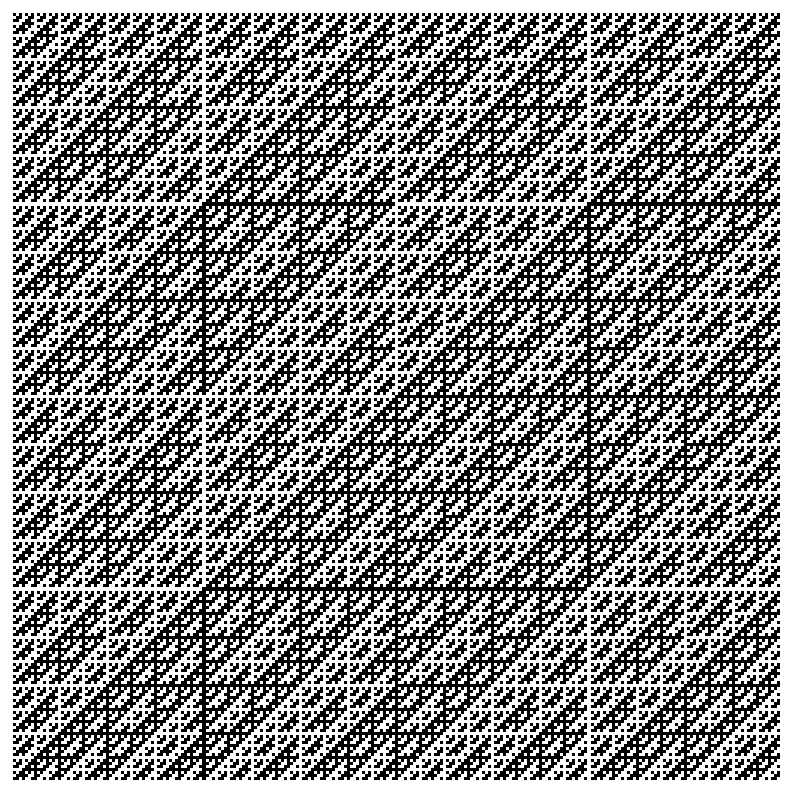

In [39]:
def hadamard(n):
    """
    Create a Hadamard matrix of size n
    """
    if n == 1:
        return np.array([[1]])
    else:
        H = hadamard(n // 2)
        return np.block([[H, H], [H, -H]])

plt.figure(figsize=(10, 10))
a = hadamard(2**8).astype(float)

plt.imshow(a, cmap='gray')
plt.axis('off')
        

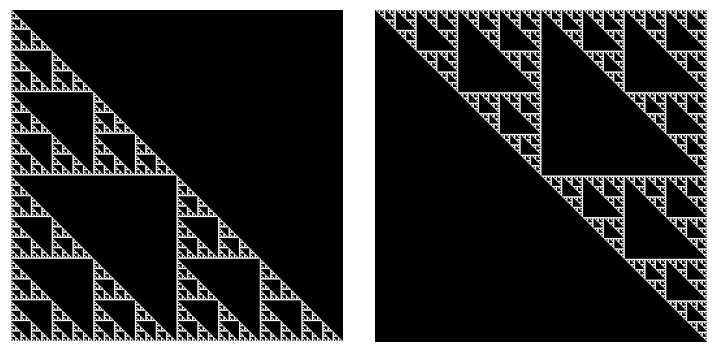

In [29]:

ll, uu = model.lu(a)


plt.figure(figsize=(9, 4.5))
plt.subplot(121)
plt.imshow(ll, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(uu.astype(bool), cmap='gray')
plt.axis('off')
## show plots closer together
plt.subplots_adjust(wspace=0.1)


## Applying PageRank to the coauthorship graph

We can now apply the PageRank algorithm to the coauthorship graph.

In [75]:
A = nx.adjacency_matrix(g2).todense() # get the binary adjacency matrix of the graph

def find_pagerank(A, alpha=0.85, verbose=False):
    """
    Find the PageRank of a graph using matrix inversion

    Args:
        A (np.ndarray): The adjacency matrix of the graph
        alpha (float): The damping factor. The default value is 0.85

    Returns:
        page_rank (np.ndarray): The PageRank of each node
    """
    D = np.diag(np.sum(A, axis=1)) # get the degree matrix
    M = (1 - alpha) * (np.eye(A.shape[0]) - alpha * np.matmul(A, np.linalg.inv(D)))

    if verbose:
        print(f"Condition number of M: {np.linalg.cond(M)}", flush=True)

    ## use our LU solver
    page_rank = np.linalg.inv(M) @ np.ones(M.shape[0])

    return page_rank


page_rank1 = find_pagerank(A, alpha=0.05, verbose=True)
plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank2), edge_color='gray', width=0.01, cmap='viridis', alpha=0.2)
plt.title(f"PageRank centrality with alpha=0.85")
plt.show()


page_rank2 = find_pagerank(A, alpha=0.95, verbose=True)
plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=200, node_color=np.log10(page_rank2), edge_color='gray', width=0.01, cmap='viridis', alpha=0.2)
plt.title(f"PageRank centrality with alpha=0.95")
plt.show()
